## 크롤링 기상데이터 수집

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
import time
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.select import Select
dri=webdriver.Chrome("c:/Users/admin/chromedriver_win32/chromedriver.exe")
dri.get("https://data.kma.go.kr/data/grnd/selectAwsRltmList.do?pgmNo=56&tabNo=1")
# 로그인은 알아서 하고

In [ ]:
# 2012 2023

Select(dri.find_element(by="id",value="dataFormCd")).select_by_value("F00503")  # 분자료선택
Select(dri.find_element(by="id",value="startDt")).select_by_value("2012")       # 시작일
Select(dri.find_element(by="id",value="endDt")).select_by_value("2017")         # 종료일
dri.find_element(by=By.XPATH,value='//*[@id="ztree_1_check"]').click()       # 전체자료클릭
Select(dri.find_element(by="id",value="schListCnt_list")).select_by_value("50") # 자료수 50개
dri.find_element(by=By.XPATH,value='//*[@id="dsForm"]/div[3]/button').click()# 조회


In [ ]:


a1='//*[@id="checkAll"]'
a2='//*[@id="wrap_content"]/div[4]/div[2]/div[2]/div[2]/a'
a3='//*[@id="reqstPurposeCd7"]'
a4='//*[@id="wrap-datapop"]/div/div[2]/div/a[2]'
a5='//*[@id="wrap_content"]/div[4]/div[2]/div[2]/div[1]/ul/li'

while True:
    while True:
        
        try:
            #모두 선택 버튼
            WebDriverWait(dri, 10).until(EC.element_to_be_clickable((By.XPATH, a1)))
            dri.find_element(by=By.XPATH,value=a1).click()
            #print(1)
            break
        except:
            pass
    #현재페이지 인덱스
    #webDriverWait(dri, 10).until(EC.presence_of_element_located((By.CLASS_NAME, "on"))
    while True:
        try:
            p123=-1
            if dri.find_elements(by=By.CLASS_NAME,value="on")[p123]=='':
                p123=-2
                
            ind=int((dri.find_elements(by=By.CLASS_NAME,value="on")[p123]).text)%10
            #print(ind)
            if ind==0:
                ind=10
            ind+=2
            #print(2)
            break
        except:
            pass
    while True:
        try:
            # 다운로드 클릭
            WebDriverWait(dri, 30).until(EC.element_to_be_clickable((By.XPATH, a2)))                        
            dri.find_element(by=By.XPATH,value=a2).click()
            #print(3)
            break
        except:
            pass
    while True:
        try:
            # 용도선택
            WebDriverWait(dri, 30).until(EC.element_to_be_clickable((By.XPATH, a3)))
            dri.find_element(by=By.XPATH,value=a3).click()
            #print(4)
            break
        except:
            pass
    while True:
        try:
            #신청클릭
            WebDriverWait(dri, 30).until(EC.element_to_be_clickable((By.XPATH, a4)))
            dri.find_element(by=By.XPATH,value=a4).click()
            #print(5)
            break
        except:
            pass
    
    while True:
        try:
            #다음페이지버튼
            WebDriverWait(dri, 30).until(EC.presence_of_element_located((By.XPATH, a5)))
            (dri.find_elements(by=By.XPATH,value=a5)[ind]).click()
            #print(6)
            break
        except:
            pass
    print(ind)
    

## 데이터 전처리

In [ ]:
#기상정보 압출풀기 하드 폭파과정
import zipfile
import os

if not os.path.exists("temp"):
    os.mkdir("temp")
    
a=os.listdir("data")
for i in a:
    zipfile.ZipFile(f'data/{i}').extractall('temp')


if not os.path.exists("temp1"):
    os.mkdir("temp1")
a=os.listdir("temp")
for i in a:
    zipfile.ZipFile(f'temp/{i}').extractall('temp1')
print("압축 끝")
    
    
#zipfile.ZipFile('rltkd').extractall()

In [ ]:
#지역별로 파일 정리
import pandas as pd
import os

if not os.path.exists("temp2"):
    os.mkdir("temp2")
    
a=os.listdir("temp1")
aa=set(map(lambda x:x.split("_")[2],a))
# 지역별로 나누기
l=len(aa)
n=1
for i in aa:
    # 해당하느 지역 모두 가져오기
    p=list(filter(lambda x:x.split("_")[2]==i,a))
    t=pd.DataFrame()
    for j in p:
        #합쳐서 save
        data=pd.read_csv("temp1/"+j,encoding="cp949")
        # 지역마다 열 이름 다름
        if "시간" in data.columns:
            data=data.rename(columns={"시간":"일시",
                                 "1분강수량(mm)":"1분 강수량(mm)"})
        
        data=data[data["일시"].apply(lambda x: int(x.split(":")[-1])%5==0)]
        #data.index=pd.to_datetime(data["일시"])
        #data.drop("일시",axis=1,inplace=True)
        #data=data.resample("5T").mean()
        
        t=pd.concat([t,data])
    t.sort_values("일시").drop_duplicates().to_csv(f"temp2/{i}.csv",encoding="utf-8-sig",index=False)
    print(l-n,i)
    n+=1
        


In [ ]:
import os
import pandas as pd

if not os.path.exists("last"):
    os.mkdir("last")
#os.listdir("temp2/")

for i in set(os.listdir("temp2/"))&set(os.listdir("새 폴더/temp2/")):

    # 두개 가져와 합치기
    t=pd.concat([pd.read_csv(f"temp2/{i}"),pd.read_csv(f"새 폴더/temp2/{i}")])
    # 없는 시간 빠짐없이
    
    t=t.fillna(method="ffill",limit=12)
    
    t.drop_duplicates("일시").to_csv(f"last/{i}",encoding="utf-8-sig",index=False)
    print(i,len(t))
    

In [ ]:
import pandas as pd
import os
# wjswldur vudrbs
df=pd.DataFrame()
for i in os.listdir("last/"):
    a=pd.read_csv(f"last/{i}")
    a.index=pd.to_datetime(a["일시"])
    df=pd.concat([df,a])
    df=df.groupby(df.index).mean()#.reset_index()
    print(i)
df.fillna(method="ffill").to_csv("all_mean.csv",encoding="utf-8-sig")

In [1]:
import pandas as pd

a=pd.read_csv("5분 수급현황데이터(20120601~20220407).csv",encoding="cp949")
b=pd.read_csv("한국전력거래소_5분단위 전력수급현황_20230430.csv",encoding="cp949")

In [2]:
c=pd.concat([a,b]).drop_duplicates("기준일시")
c["기준일시"]=pd.to_datetime(c["기준일시"])
df=pd.read_csv("sukub.csv",encoding="cp949")
df["기준일시"]=pd.to_datetime(df["기준일시"],format="%Y%m%d%H%M%S")
df.columns=c.columns
c=pd.concat([c,df]).drop_duplicates("기준일시")

c1=pd.read_csv("all_mean.csv")

In [3]:
c1["일시"]=pd.to_datetime(c1["일시"])

In [4]:
c=pd.merge(c,c1[["일시","풍속(m/s)","기온(°C)","습도(%)"]],left_on="기준일시",right_on="일시")
c=c.sort_values("기준일시")

In [5]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import joblib,os, warnings,datetime
import pandas as pd
import numpy as np
from pytimekr import pytimekr
dd=c
list1=[]
for i in range(2012,2023):    
    list1+=list(map(lambda x:x.strftime("%Y-%m-%d"),pytimekr.holidays(i))) #holidays메소드는 리스트 형태로 관련값 반환
#dd["휴일"]=pd.to_datetime(dd["기준일시"]).apply(lambda x:x.weekday()>4)
def holi(x):
    if x.weekday()==5:
        return 1
    elif x.weekday()==6 or x.strftime("%Y-%m-%d") in list1:
        return 0
    else:
        return 2
#dd["휴일"]=pd.to_datetime(dd["기준일시"]).apply(lambda x:x.strftime("%Y-%m-%d") in list1 or x.weekday()>4)
dd["휴일"]=pd.to_datetime(dd["기준일시"]).apply(holi)

dd["we"]=pd.to_datetime(dd["기준일시"]).apply(lambda x:x.weekday())
a=np.array(dd["기준일시"].apply(lambda x:str(x).replace("-"," ").replace(":"," ").split()).to_list())#
aa=a.T
dd["y"]=aa[0]
dd["m"]=aa[1]
dd["d"]=aa[2]
dd["h"]=aa[3]
dd["b"]=aa[4]

#dd["12h"]=dd["h"].apply(lambda x:x=="12")
dd.to_csv("5m_ele.csv",encoding="utf-8-sig")

In [1]:
#dd.to_csv("dd.csv",encoding="utf-8-sig")
import pandas as pd
dd=pd.read_csv("5m_ele.csv")
dd.index=pd.to_datetime(dd["기준일시"])
e=pd.read_csv("제조업_생산능력_및_가동률지수_2020100__20230630102930.csv",encoding="cp949",skiprows=2,names=["시점","생산능력지수","가동률지수(원지수)","가동률지수(계절조정)"])
e.index=pd.to_datetime(e["시점"].apply(lambda x : x.split(" ")[0]))
e=e.iloc[:-1,1:3]
dd=pd.merge(dd,e,left_index=True,right_index=True,how="outer").fillna(method="ffill")
dd.to_csv("5m_ele.csv",encoding="utf-8-sig")

In [2]:
dd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1163521 entries, 2012-06-01 00:00:00 to 2023-06-28 00:55:00
Data columns (total 22 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1163521 non-null  int64  
 1   기준일시        1163521 non-null  object 
 2   공급능력(MW)    1163521 non-null  float64
 3   현재수요(MW)    1163521 non-null  float64
 4   최대예측수요(MW)  1163521 non-null  float64
 5   공급예비력(MW)   1163521 non-null  float64
 6   공급예비율(퍼센트)  1163521 non-null  float64
 7   운영예비력(MW)   1163521 non-null  float64
 8   운영예비율(퍼센트)  1163521 non-null  float64
 9   일시          1163521 non-null  object 
 10  풍속(m/s)     1163521 non-null  float64
 11  기온(°C)      1163521 non-null  float64
 12  습도(%)       1163521 non-null  float64
 13  휴일          1163521 non-null  int64  
 14  we          1163521 non-null  int64  
 15  y           1163521 non-null  int64  
 16  m           1163521 non-null  int64  
 17  d           1163521 non-null  in

In [3]:
dd.columns

Index(['Unnamed: 0', '기준일시', '공급능력(MW)', '현재수요(MW)', '최대예측수요(MW)', '공급예비력(MW)',
       '공급예비율(퍼센트)', '운영예비력(MW)', '운영예비율(퍼센트)', '일시', '풍속(m/s)', '기온(°C)',
       '습도(%)', '휴일', 'we', 'y', 'm', 'd', 'h', 'b', '생산능력지수', '가동률지수(원지수)'],
      dtype='object')

## 전처리끝 여기부터 학습

In [1]:
import pandas as pd
import numpy as np

dd=pd.read_csv("5m_ele.csv")
dd.index=pd.to_datetime(dd["기준일시"])
ddd=dd[["현재수요(MW)",'공급능력(MW)',"y","d","h","we",'휴일',"기온(°C)"]].astype(float)
rr=ddd.shape[1]
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#ddd=dd[["현재수요(MW)","m","h","we","기온(°C)","생산능력지수","가동률지수(원지수)"]]
mi=ddd.min()
ma=ddd.max()
ddd=((ddd-mi)/(ma-mi))#.values


#ff=MinMaxScaler(feature_range=(0,1))
#ddd=ff.fit_transform(ddd.values.reshape(-1,rr))
#ddd=pd.DataFrame(ddd)

import numpy as np

def step(df,r=12*6,time=72):
    x=np.empty((len(df)-r-time,r,rr))
    y=np.empty((len(df)-r-time,time,1))
    for i in range(len(df)-r-time):
        x[i]=df[i:i+r]
        y[i]=df[i+r:i+r+time,[0]]
        
    return np.array(x),np.array(y)
def step_many(df,r=12*6,time=72):
    x=np.empty(((len(df)-r-time)//r,r,rr))
    y=np.empty(((len(df)-r-time)//r,time,1))
    n=0
    for i in range(0,len(df)-r-time,r):
        x[n]=df[i:i+r]
        y[n]=df[i+r:i+r+time,[0]]
        n+=1
        if n==len(x):
            break
    return np.array(x),np.array(y)
rlp=12*6


tr=ddd[:"2023-03-12"].values

vl=ddd["2023-03-12 18:00:00":"2023-03-20 06:00:00"].values
xy=ddd["2023-03-12 18:00:00":].values

time_te=ddd["2023-03-13":"2023-03-19"].index
time_xy=ddd["2023-03-13":].index

x_tr,y_tr=step(tr,r=rlp)
x_te,y_te=step_many(vl,r=rlp)
xa,ya=step_many(xy,r=rlp)


# train test
#x=m[0].reshape((m[0].shape[0],m[0].shape[1],rr))
#y=m[1].reshape((m[1].shape[0],1,1))
print(tr.shape,vl.shape,x_tr.shape,x_te.shape,xa.shape)

(1132709, 8) (2161, 8) (1132565, 72, 8) (28, 72, 8) (426, 72, 8)


## LSTM 모델

In [3]:
from keras.layers import LayerNormalization,Input,Bidirectional,LSTM,Dense,Dropout,BatchNormalization,Activation,GRU,LSTMV2,Conv1D,AvgPool1D,MaxPool1D,TimeDistributed,MaxPooling1D,Flatten,SimpleRNN
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from keras.metrics import MeanAbsolutePercentageError,mean_absolute_percentage_error
from keras.optimizers import SGD,Adam,RMSprop,Nadam,adamw_experimental,Adadelta


#from keras.losses import MeanAbsolutePercentageError
import tensorflow as tf
import keras

tf.random.set_seed(123)


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:  # gpu가 있다면, 용량 한도를 5GB로 설정
  tf.config.experimental.set_virtual_device_configuration(gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2*1800)])

import os
model=Sequential([
    #TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=( rlp, rr,1)),
    #TimeDistributed(MaxPooling1D(pool_size=2)),
    #TimeDistributed(Flatten()),
    Input(batch_shape=(None, rlp, rr)),
    Bidirectional(LSTM(64,return_sequences=True)),
    Dropout(0.32),
    Bidirectional(LSTM(32,return_sequences=True)),
    Dropout(0.32),
    Bidirectional(LSTM(16,return_sequences=True)),
    Dropout(0.32),
    Bidirectional(LSTM(8,return_sequences=True)),
    Dropout(0.25),
    
    
    #Bidirectional(LSTM(4,return_sequences=True)),
    #Dropout(0.32),
    #Bidirectional(LSTM(1,return_sequences=True)),
    
    #Dropout(0.32),
    #Dropout(0.2),
    #TimeDistributed(Dense(2)),
    #TimeDistributed(Dropout(0.5)),
    TimeDistributed(Dense(1)),
    Activation("sigmoid"),
    
])
#model.load_weights("bestmodel.h5")
model.compile(loss="mae",optimizer=Adam(learning_rate=0.001))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 72, 128)          37888     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 72, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 72, 64)           41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 72, 64)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 72, 32)           10368     
 nal)                                                            
                                                        

In [4]:
from keras.callbacks import ModelCheckpoint,EarlyStopping

tf.random.set_seed(123)

best=ModelCheckpoint(filepath="bestmodel2.h5",
                monitor="val_loss",
                save_best_only=True,
                    verbose=1)

history=model.fit(x_tr,
                  y_tr,
                  batch_size=500,
                  epochs=30,
                  validation_data=(x_te,y_te),
                  validation_batch_size=32,
                  callbacks=[best])

Epoch 1/30
2266/2266 [==============================] - ETA: 0s - loss: 0.0295
Epoch 1: val_loss improved from inf to 0.02821, saving model to bestmodel2.h5
2266/2266 [==============================] - 152s 62ms/step - loss: 0.0295 - val_loss: 0.0282
Epoch 2/30
2266/2266 [==============================] - ETA: 0s - loss: 0.0228
Epoch 2: val_loss improved from 0.02821 to 0.01969, saving model to bestmodel2.h5
2266/2266 [==============================] - 136s 60ms/step - loss: 0.0228 - val_loss: 0.0197
Epoch 3/30
2265/2266 [============================>.] - ETA: 0s - loss: 0.0213
Epoch 3: val_loss improved from 0.01969 to 0.01677, saving model to bestmodel2.h5
2266/2266 [==============================] - 136s 60ms/step - loss: 0.0213 - val_loss: 0.0168
Epoch 4/30
2265/2266 [============================>.] - ETA: 0s - loss: 0.0205
Epoch 4: val_loss did not improve from 0.01677
2266/2266 [==============================] - 136s 60ms/step - loss: 0.0205 - val_loss: 0.0198
Epoch 5/30
2266/226

In [1]:
from keras.models import load_model
model=load_model("bestmodel2.h5")

In [9]:
pred=model.predict(x_te,batch_size=64)

1/1 [==============================] - 2s 2s/step


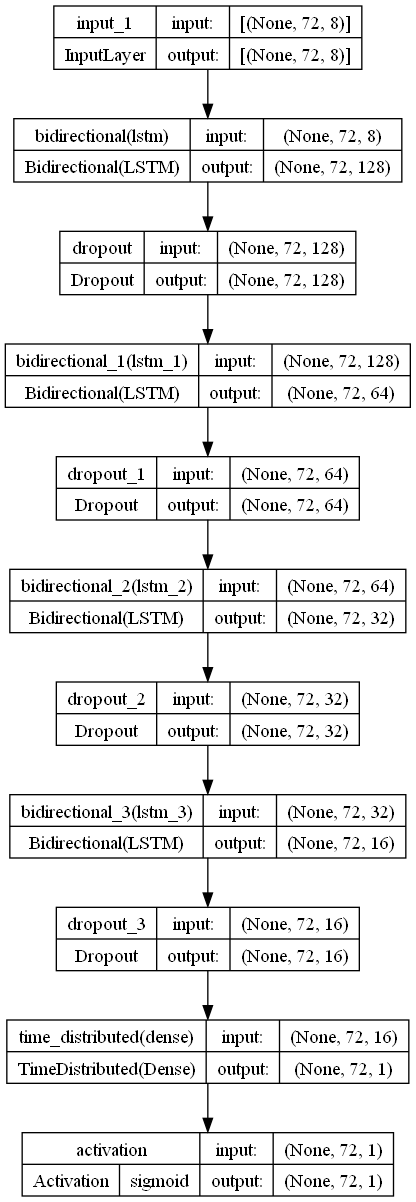

In [3]:
from keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_activations=True,to_file='model.png')

In [10]:
x_te.shape,y_te.shape,pred.shape

((28, 72, 8), (28, 72, 1), (28, 72, 1))

In [11]:
pred1=pred.reshape(-1,1)*(ma[0]-mi[0])+mi[0]
yp=y_te.reshape(-1,1)*(ma[0]-mi[0])+mi[0]
yp2=ya.reshape(-1,1)*(ma[0]-mi[0])+mi[0]
pred2=model.predict(xa).reshape(-1,1)*(ma[0]-mi[0])+mi[0]

14/14 [==============================] - 0s 31ms/step


## 결과

In [12]:
from sklearn.metrics import mean_absolute_percentage_error
print("3-13 ~ 3-19 MAPE :" , mean_absolute_percentage_error(yp,pred1))
print("3-13 ~ 6-30 MAPE :" ,mean_absolute_percentage_error(yp2,pred2))

3-13 ~ 3-19 MAPE : 0.012289473832069766
3-13 ~ 6-30 MAPE : 0.019794951851200355


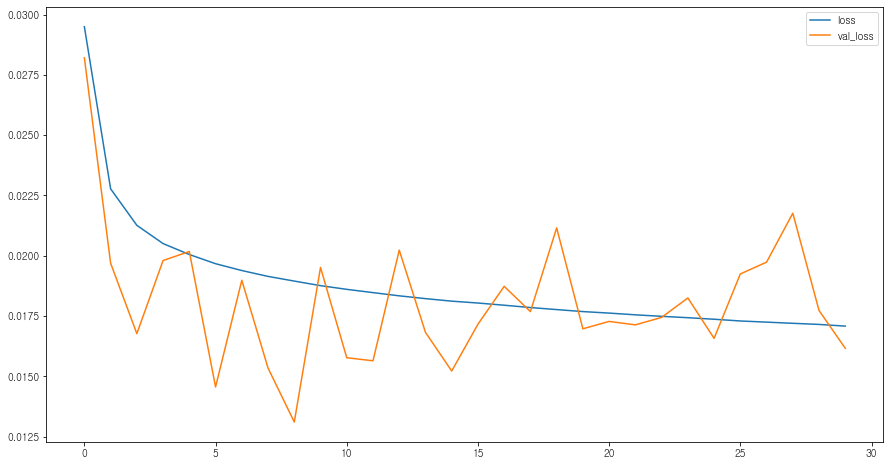

In [9]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline
plt.figure(figsize=(15,8))
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
#plt.title("map_loss")
plt.legend()

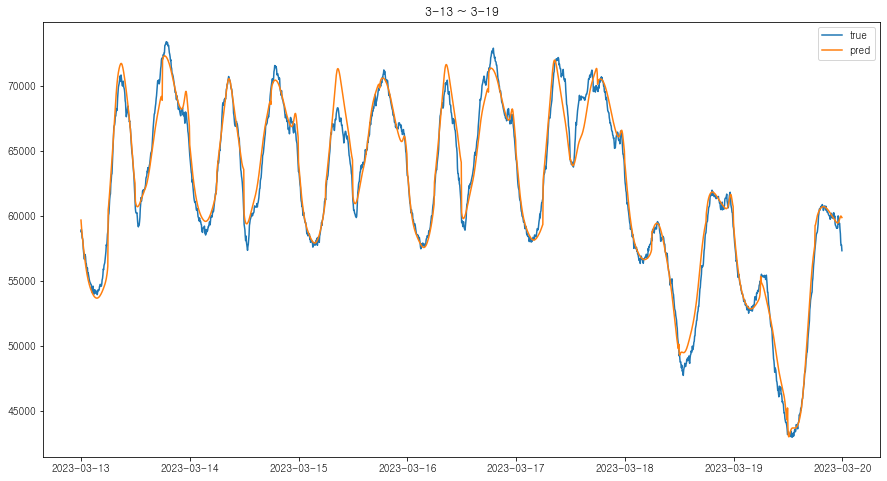

In [19]:
plt.figure(figsize=(15,8))
plt.plot(time_te,yp,label="true")
plt.plot(time_te,pred1,label="pred")


plt.title("3-13 ~ 3-19")
plt.legend()

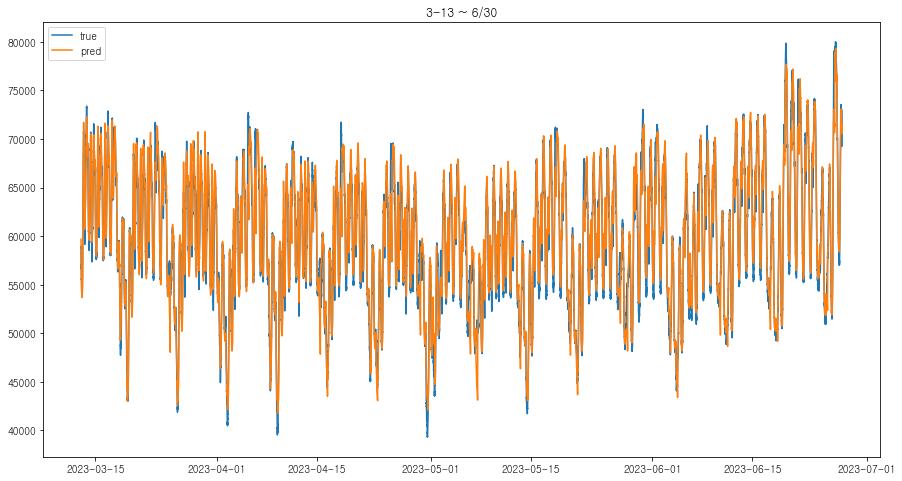

In [20]:
#%matplotlib inline
plt.figure(figsize=(15,8))
plt.plot(time_xy[:len(yp2)],yp2,label="true")
plt.plot(time_xy[:len(yp2)],pred2,label="pred")
plt.title("3-13 ~ 6/30")
plt.legend()

## 실시간 데이터 사용 6시간 예측 

C:\Users\a\AppData\Local\Temp/ipykernel_3716/2471544003.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  a=pd.DataFrame(np.array(u.find("table").find_all("td")).reshape(-1,25)[:,1:]).applymap(f).mean().dropna()[-7:].values
No handles with labels found to put in legend.


현재시간 : 2023-07-10 09:00:38.113777
1/1 [==============================] - 0s 32ms/step


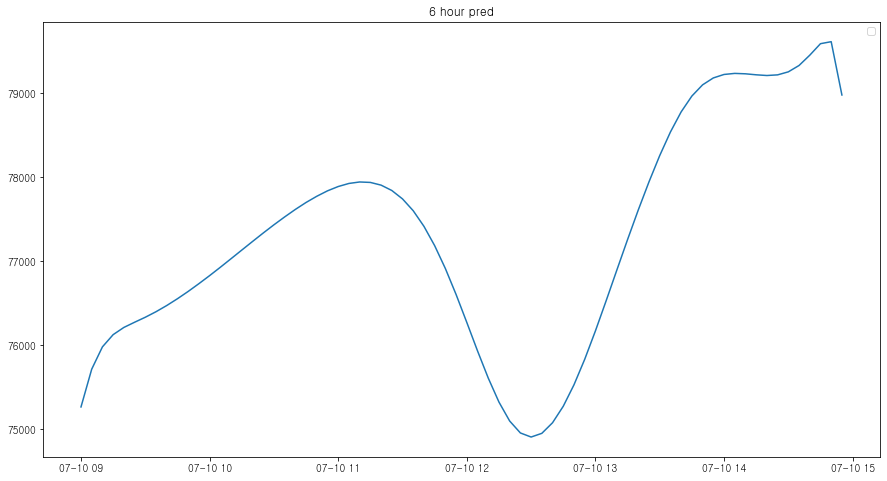

In [13]:
import requests
from bs4 import BeautifulSoup
import requests
import xml
import numpy as np
import xmltodict
import pandas as pd
import datetime
import pandas  as pd

# 실시간 날씨 데이터  -6 시간 
html=requests.get(f"https://www.weather.go.kr/w/obs-climate/land/city-obs.do?auto_man=m&stn=0&dtm=&type=t11&reg=100&tm=").content
u=BeautifulSoup(html,"lxml")
def f(x):
    try:
        return float(x)
    except:
        np.nan
a=pd.DataFrame(np.array(u.find("table").find_all("td")).reshape(-1,25)[:,1:]).applymap(f).mean().dropna()[-7:].values
p=np.array([])
for i in range(len(a)-1):
    p=np.hstack([p,np.linspace(a[i],a[i+1],12)])

# 실시간 api 전력정보
with open("apikey.txt","r") as f:
    key=f.readline()
u=requests.get(f"https://openapi.kpx.or.kr/openapi/sukub5mToday/getSukub5mToday?serviceKey={key}")
df=pd.DataFrame(xmltodict.parse(u.text)["response"]["body"]["items"]["item"][-72:])
def f(x):
    w=x.weekday()
    if w==5:
        wh=1
    elif w==6:
        wh=0
    else:
        wh=2
    return wh
df["y"]=df["baseDatetime"].apply(lambda x:x[:4])
df["d"]=df["baseDatetime"].apply(lambda x:x[6:8])
df["h"]=df["baseDatetime"].apply(lambda x:x[8:10])
df["we"]=pd.to_datetime(df["baseDatetime"]).apply(lambda x: x.weekday())
df["holi"]=pd.to_datetime(df["baseDatetime"]).apply(f)
df["temp"]=p

df=df[["currPwrTot","suppAbility","y","d","h","we","holi","temp"]].astype(float)
df.columns=mi.index
test=((df-mi)/(ma-mi)).values

# 현재 데이터로 6시간 예측

a=datetime.datetime.now()
m=(a.minute//5)*5
start=a.replace(minute=m,second=0,microsecond=0)
end=start+datetime.timedelta(hours=5.99)


plt.figure(figsize=(15,8))


plt.legend()

idx=pd.date_range(start,end,freq="5T")
print("현재시간 :",a)
data=(model.predict(test.reshape(1,72,8))*(ma[0]-mi[0])+mi[0]).reshape(-1,1)
plt.title("6 hour pred")
plt.plot(idx,data)